In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from tensorflow import keras
from tensorflow.keras import layers

## Loading Dataset

In [2]:
url = 'https://raw.githubusercontent.com/kderkba/Wasserstein-GAN-Keras/main/train.csv'

fin_df = pd.read_csv(url,header=None,names=['Indices','Index1','Index2','Index3','Index4'])
del fin_df[fin_df.columns[0]]

In [3]:
fin_df.head()

,Index1,Index2,Index3,Index4
0,0.012495,0.011126,0.003252,0.006625
1,0.011439,0.002691,0.001206,0.006947
2,0.000632,0.007277,0.004049,0.000074
3,0.017828,0.028210,0.007758,0.007382
4,0.021115,0.019642,0.009238,0.011499


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f449bb61d90>,
      dtype=object)

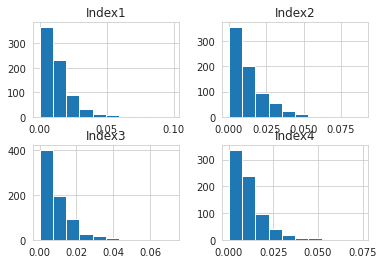

In [4]:
fin_df.hist()

In [5]:
fin_df.shape

(746, 4)

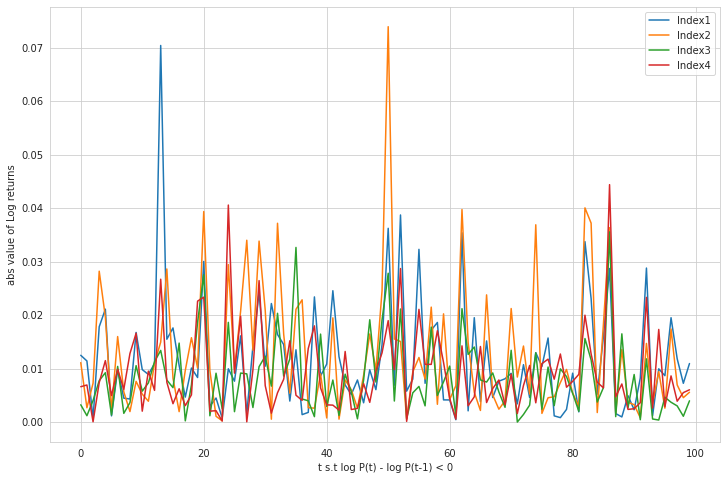

In [ ]:
plt.figure(figsize=(12,8))
for col in fin_df:
  plt.plot(fin_df[col][:100],label=col)
plt.xlabel('t s.t log P(t) - log P(t-1) < 0')
plt.ylabel('abs value of Log returns')
plt.legend()
plt.show()

## Metric implementation

In [6]:
# def anderson_darling_dist(X: np.ndarray, X_tilde: np.ndarray) -> np.ndarray:
#     assert X.shape == X_tilde.shape
#     n, d = X.shape
#     u_tilde = empirical_distribution_func(X, X_tilde)
#     i = np.arange(1, n + 1).repeat(d).reshape(n, d)
#     # (2 * i - 1) * (log(u_tilde_ik) + log(1 - u_tilde_(n - i + 1)k))
#     W = (2 * i - 1) * (np.log(u_tilde) + np.log(1 - np.flip(u_tilde, axis=0)))
#     W = -n - W.mean(axis=0)
#     return W.mean()

# def empirical_distribution_func(X: np.ndarray, X_tilde: np.ndarray) -> np.ndarray:
#     assert X.shape == X_tilde.shape
#     n, d = X.shape
#     X_tilde.sort(axis=0)  # order independent
#     # X_jk <= X_tilde_ik, k= 1, ..., d
#     u_tilde = np.tile(X, (n, 1, 1)) <= np.repeat(X_tilde, n, axis=0).reshape(n, n, -1)
#     # 1 / (n + 2) * (sum_j (X_jk <= X_tilde_ik) + 1)
#     u_tilde = 1. / (n + 2) * (u_tilde.sum(axis=1) + 1)
#     return u_tilde  

# def absolute_kendall_error(X: np.ndarray, X_tilde: np.ndarray) -> np.ndarray:
#     assert X.shape == X_tilde.shape
#     Z = kendalls_dependence_func(X)
#     Z_tilde = kendalls_dependence_func(X_tilde)
#     return abs(np.sort(Z) - np.sort(Z_tilde)).mean()  # order independent

# def kendalls_dependence_func(X: np.ndarray) -> np.ndarray:
#     n, d = X.shape
#     # X_jk < X_ik, k= 1, ..., d
#     Z = np.tile(X, (n, 1, 1)) < np.repeat(X, n, axis=0).reshape(n, n, -1)
#     # {X_j1 < X_i1, ..., X_jd < X_id}
#     Z = Z.sum(axis=-1) == np.full((n, n), d)
#     # 1 / (n - 1) * sum_j (1 * {X_j1 < X_i1, ..., X_jd < X_id})
#     Z = 1. / (n - 1) * Z.sum(axis=-1)
#     return Z

def anderson_darling_dist(X: np.ndarray, X_tilde: np.ndarray) -> np.ndarray:
    X, X_tilde = np.copy(X), np.copy(X_tilde)
    assert X.shape == X_tilde.shape
    n, d = X.shape
    u_tilde = empirical_distribution_func(X, X_tilde)
    i = np.arange(1, n + 1).repeat(d).reshape(n, d)
    # (2 * i - 1) * (log(u_tilde_ik) + log(1 - u_tilde_(n - i + 1)k))
    W = (2 * i - 1) * (np.log(u_tilde) + np.log(1 - np.flip(u_tilde, axis=0)))
    W = -n - W.mean(axis=0)
    return W.mean()

def empirical_distribution_func(X: np.ndarray, X_tilde: np.ndarray) -> np.ndarray:
    X, X_tilde = np.copy(X), np.copy(X_tilde)
    assert X.shape == X_tilde.shape
    n, d = X.shape
    X_tilde.sort(axis=0)  # order independent
    # X_jk <= X_tilde_ik, k= 1, ..., d
    u_tilde = np.tile(X, (n, 1, 1)) <= np.repeat(X_tilde, n, axis=0).reshape(n, n, -1)
    # 1 / (n + 2) * (sum_j (X_jk <= X_tilde_ik) + 1)
    u_tilde = 1. / (n + 2) * (u_tilde.sum(axis=1) + 1)
    return u_tilde  

def absolute_kendall_error(X: np.ndarray, X_tilde: np.ndarray) -> np.ndarray:
    X, X_tilde = np.copy(X), np.copy(X_tilde)
    assert X.shape == X_tilde.shape
    Z = kendalls_dependence_func(X)
    Z_tilde = kendalls_dependence_func(X_tilde)
    return abs(np.sort(Z) - np.sort(Z_tilde)).mean()  # order independent

def kendalls_dependence_func(X: np.ndarray) -> np.ndarray:
    X = np.copy(X)
    n, d = X.shape
    # X_jk < X_ik, k= 1, ..., d
    Z = np.tile(X, (n, 1, 1)) < np.repeat(X, n, axis=0).reshape(n, n, -1)
    # {X_j1 < X_i1, ..., X_jd < X_id}
    Z = Z.sum(axis=-1) == np.full((n, n), d)
    # 1 / (n - 1) * sum_j (1 * {X_j1 < X_i1, ..., X_jd < X_id})
    Z = 1. / (n - 1) * Z.sum(axis=-1)
    return Z

## W-GAN

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
PT_SHAPE = (1,4)
BATCH_SIZE = 16

train_data = fin_df.sample(frac=0.8,random_state=25)
test_data = fin_df.drop(train_data.index)

train_data = train_data.to_numpy()
train_data = train_data.reshape(train_data.shape[0],*PT_SHAPE)

test_data = test_data.to_numpy()
test_data = test_data.reshape(test_data.shape[0],*PT_SHAPE)
print(f"shape of train set: {train_data.shape}")
print(f"shape of test set: {test_data.shape}")

shape of train set: (597, 1, 4)
shape of test set: (149, 1, 4)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,LeakyReLU

In [ ]:
### discriminator

def discriminator_model():
  pt_input = layers.Input(shape=PT_SHAPE)
  x = layers.Dense(32)(pt_input)
  x = layers.LeakyReLU()(x)
  x = layers.Dense(32)(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dense(32)(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dense(16)(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dense(16)(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dense(8)(x)
  #x = layers.LeakyReLU(0.2)(x)
  x = layers.Flatten()(x)
  #x = layers.Dropout(0.2)(x)
  x = layers.Dense(1)(x)
  
  # model = Sequential()
  # model.add(Flatten(input_shape=PT_SHAPE))
  # model.add(Dense(32))
  # model.add(LeakyReLU(alpha=0.2))
  # model.add(Dense(64))
  # model.add(LeakyReLU(alpha=0.2))
  # model.add(Dense(32))
  # model.add(LeakyReLU(alpha=0.2))
  # model.add(Dense(1, activation='sigmoid'))

  d_model = keras.models.Model(pt_input, x, name="discriminator")
  return d_model

In [ ]:
discriminator_model().summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 dense_37 (Dense)            (None, 1, 32)             160       
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 1, 32)             0         
                                                                 
 dense_38 (Dense)            (None, 1, 32)             1056      
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 1, 32)             0         
                                                                 
 dense_39 (Dense)            (None, 1, 32)             1056      
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 1, 32)           

In [ ]:
##generator

def generator_model(latent_dim):
    noise = layers.Input(shape=(latent_dim,))
    
    x = layers.Dense(4, use_bias=False)(noise)
    #x = layers.BatchNormalization()(x) #normalize range, allows distrib of data to remain same 
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((1,4))(x)
    x = layers.Dense(120)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(16)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(16)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(5)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(5)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(5)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(5)(x)
    x = layers.LeakyReLU()(x)
    #x = layers.Dense(8)(x)
    #x = layers.LeakyReLU(0.2)(x)
    x = layers.Dense(4)(x)
    x = layers.Reshape((1,4))(x)
    
    g_model = keras.models.Model(noise, x, name="generator")
    return g_model

In [ ]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=5,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_pts, fake_pts):
        """ Calculates the gradient penalty."""
        alpha = tf.random.normal([batch_size, 1, 1], 0.0, 1.0)
        diff = fake_pts - real_pts
        interpolated = real_pts + alpha * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = gp_tape.gradient(pred, [interpolated])[0]

        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_pts):
        
        if isinstance(real_pts, tuple):
            real_pts = real_pts[0]

        # Get the batch size
        batch_size = tf.shape(real_pts)[0]
        
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                #fake pts from latent vector
                fake_pts = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake pts
                fake_logits = self.discriminator(fake_pts, training=True)
                
                # Get the logits for the real images
            
                real_logits = self.discriminator(real_pts, training=True)
                
                # Calculate the discriminator loss 
                d_cost = self.d_loss_fn(real_pt=real_logits, fake_pt=fake_logits)
                gp = self.gradient_penalty(batch_size, real_pts, fake_pts)
                d_loss = d_cost + gp * self.gp_weight
  
            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_pts = self.generator(random_latent_vectors, training=True)
            gen_pt_logits = self.discriminator(generated_pts, training=True)
            g_loss = self.g_loss_fn(gen_pt_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        #test_latent_vectors = tf.random.normal(shape=(self.test_set.shape[0], self.latent_dim))
        #test_generated_pts = self.generator(test_latent_vectors, training=False)
        #test_generated_pts = test_generated_pts.numpy()[:,0,:]
        #k_error = absolute_kendall_error(self.test_set[:149,0,:], test_generated_pts[:,0,:])
        #a_error = anderson_darling_dist(self.test_set[:149,0,:], test_generated_pts[:,0,:])
        return {"d_loss": d_loss, "g_loss": g_loss}#, "k_error": k_error, "a_error":a_error}


In [ ]:
## metrics

def metrics(gen_arr,training_set,num_of_pts):
  comp_set = np.zeros((num_of_pts,4))
  resh_arr = gen_arr[:num_of_pts,0,:]
  rand_idx = np.random.randint(0,high=training_set.shape[0],size=num_of_pts)
  for i in range(num_of_pts):
    comp_set[i] = training_set[rand_idx[i]]
  ake = absolute_kendall_error(resh_arr,comp_set)
  adD = anderson_darling_dist(resh_arr,comp_set)
  return {"Dependence metric":ake, "Marginals metric": adD}

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, train_set,test_set,num_pt=100, latent_dim=2):
      #number of points to display after epoch
        self.num_pt = num_pt
        self.latent_dim = latent_dim

        self.train_set = train_set
        self.test_set = test_set

        self.arr_dep_train = []
        self.arr_marg_train = []

        self.arr_dep_test = []
        self.arr_marg_test = []

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_pt, self.latent_dim))
        generated_pts = self.model.generator(random_latent_vectors)

        metric_train = metrics(generated_pts,self.train_set,self.num_pt)
        metric_test = metrics(generated_pts,self.test_set,self.num_pt)
        
        err_kendall_train = metric_train["Dependence metric"]
        err_kendall_test = metric_test["Dependence metric"]
        
        ad_dist_train = metric_train["Marginals metric"]
        ad_dist_test = metric_test["Marginals metric"]
        
        print(f'k_err_train= {np.round(err_kendall_train,2)} and k_err_test = {np.round(err_kendall_test,2)}')
        print(f'ad_dist_train= {np.round(ad_dist_train,2)} and ad_dist_test = {np.round(ad_dist_test,2)}')


        self.arr_dep_train.append(err_kendall_train)
        self.arr_marg_train.append(ad_dist_train)

        self.arr_dep_test.append(err_kendall_test)
        self.arr_marg_test.append(ad_dist_test)
    
    def on_train_end(self, logs=None):
        plt.figure(figsize=(12,8))
        plt.subplot(1,2,1)
        plt.plot(self.arr_dep_train,label="Kendall_train")
        plt.plot(self.arr_dep_test,label="Kendall test")

        plt.legend()
        plt.title("WGAN performance on the metric")
        plt.subplot(1,2,2)
        plt.plot(self.arr_marg_train,label="Anderson train")
        plt.plot(self.arr_marg_test,label="Anderson test")

        plt.legend()
        plt.title("WGAN performance on the metric")
        plt.show()

In [ ]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)


lr_schedule_gen = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=500,
    decay_rate=0.9)

lr_schedule_disc = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=500,
    decay_rate=0.9)


generator_optimizer = keras.optimizers.Adam(
    learning_rate = lr_schedule_gen
)
discriminator_optimizer =keras.optimizers.Adam(
    learning_rate = lr_schedule_disc
)

# generator_optimizer = keras.optimizers.Adam(
#     learning_rate=0.1, beta_1=0.5, beta_2=0.9,decay =1e-2
# )
# discriminator_optimizer = keras.optimizers.Adam(
#     learning_rate=0.1, beta_1=0.5, beta_2=0.9,decay =1e-2
# )
# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_pt, fake_pt):
    real_loss = tf.reduce_mean(real_pt)
    fake_loss = tf.reduce_mean(fake_pt)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_pt):
    return -tf.reduce_mean(fake_pt)

In [ ]:
d_model = discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 dense_44 (Dense)            (None, 1, 32)             160       
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 1, 32)             0         
                                                                 
 dense_45 (Dense)            (None, 1, 32)             1056      
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 1, 32)             0         
                                                                 
 dense_46 (Dense)            (None, 1, 32)             1056      
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 1, 32)           

In [ ]:
noise_dimension = 3
g_model = generator_model(latent_dim = noise_dimension)
g_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_51 (Dense)            (None, 4)                 12        
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 4)                 0         
                                                                 
 reshape_2 (Reshape)         (None, 1, 4)              0         
                                                                 
 dense_52 (Dense)            (None, 1, 120)            600       
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 1, 120)            0         
                                                                 
 dense_53 (Dense)            (None, 1, 16)             19

Epoch 1/300
35/38 [==========================>...] - ETA: 0s - d_loss: 1.5728 - g_loss: 0.0108k_err_train= 0.06 and k_err_test = 0.1
ad_dist_train= 70.98 and ad_dist_test = 83.82
38/38 [==============================] - 18s 13ms/step - d_loss: 1.5516 - g_loss: 0.0119
Epoch 2/300
35/38 [==========================>...] - ETA: 0s - d_loss: 1.1031 - g_loss: 0.0294k_err_train= 0.03 and k_err_test = 0.05
ad_dist_train= 118.35 and ad_dist_test = 110.51
38/38 [==============================] - 1s 14ms/step - d_loss: 1.0623 - g_loss: 0.0298
Epoch 3/300
35/38 [==========================>...] - ETA: 0s - d_loss: 0.5038 - g_loss: 0.0420k_err_train= 0.1 and k_err_test = 0.07
ad_dist_train= 181.76 and ad_dist_test = 190.53
38/38 [==============================] - 1s 13ms/step - d_loss: 0.5014 - g_loss: 0.0435
Epoch 4/300
36/38 [===========================>..] - ETA: 0s - d_loss: 0.2132 - g_loss: 0.0619k_err_train= 0.11 and k_err_test = 0.14
ad_dist_train= 152.19 and ad_dist_test = 149.33
38/38 [====

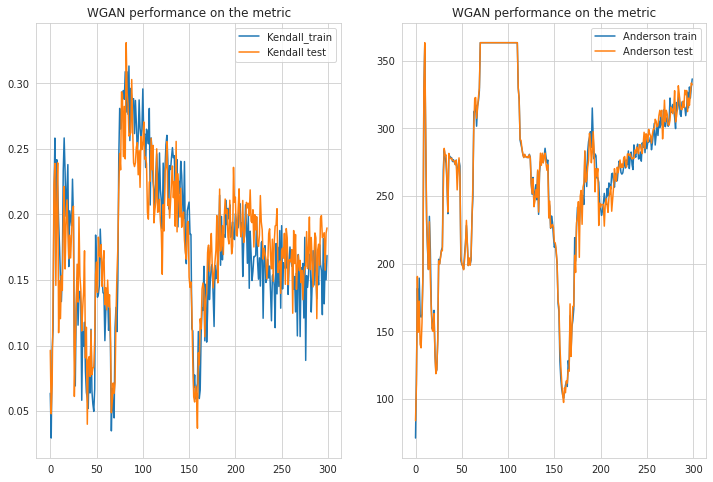

In [ ]:
# Set the number of epochs for training.
epochs = 300

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(train_set = train_data, test_set= test_data,
                 num_pt=100, latent_dim=noise_dimension)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dimension,
    discriminator_extra_steps=5,
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training the model.
loss = wgan.fit(train_data, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

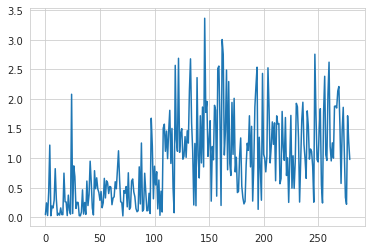

In [ ]:
plt.plot(loss.history["d_loss"][20:])

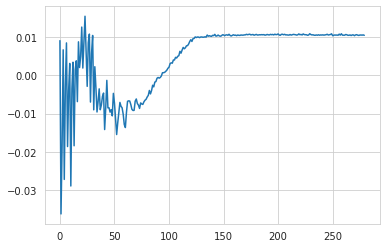

In [ ]:
plt.plot(loss.history["g_loss"][20:])

In [ ]:
url = 'https://raw.githubusercontent.com/kderkba/financial_losses/main/data_val_log_return.csv'

val_df = pd.read_csv(url,header=None,names=['Indices','Index1','Index2','Index3','Index4'])
del val_df[val_df.columns[0]]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d03d5fe10>,
      dtype=object)

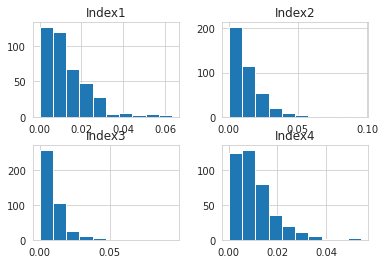

In [ ]:
val_df.hist()

## Testing GAN

In [ ]:
# kendall = []
# darling = []
# for i in range(100):
#   random_latent_vectors = tf.random.normal(shape=(149,noise_dimension))        
#   gen = g_model(random_latent_vectors, training=False)
#   gen.numpy().shape
#   kendall.append(absolute_kendall_error(test_data[:149,0,:],gen.numpy()[:,0,:]))
#   darling.append(anderson_darling_dist(test_data[:149,0,:],gen.numpy()[:,0,:]))
# print(np.mean(np.array(kendall)))
# print(np.mean(np.array(darling)))

0.037224741520043535
182.00348878024502


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e868df450>,
      dtype=object)

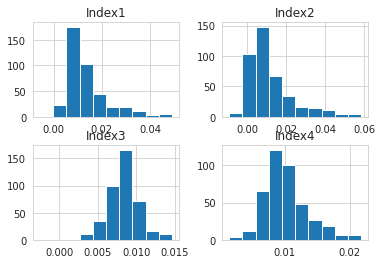

In [ ]:
random_latent_vectors = tf.random.normal(shape=(410,noise_dimension))        
gen = g_model(random_latent_vectors, training=False)

np_generated = gen.numpy().reshape(410,4)
df_generated = pd.DataFrame(np_generated, columns = ["Index1","Index2","Index3","Index4"])
df_generated.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e90149590>,
      dtype=object)

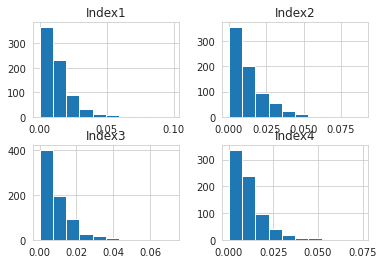

In [ ]:
fin_df.hist()

In [ ]:
#absolute_kendall_error(test_data[:149,0,:],gen.numpy()[:,0,:])

In [ ]:
#anderson_darling_dist(test_data[:149,0,:],gen.numpy()[:,0,:])